In [1]:
from pyspark.sql import SQLContext, Window 
from pyspark.sql.functions import *
from pyspark.ml.regression import LinearRegression 
from pyspark.ml.linalg import Vectors 
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import abs, sqrt
from pyspark.sql.types import FloatType
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

In [2]:
average_days = 1
horizons = [1,5,10,21,84]

In [3]:
sqlContext = SQLContext(sc)
df = sqlContext.sql("SELECT aapl.date, aapl.close FROM aapl WHERE YEAR(aapl.date) BETWEEN 1980 AND 2018")
df.show()

+-------------------+--------+
 date| close|
+-------------------+--------+
1980-12-12 00:00:00|0.513393|
1980-12-15 00:00:00|0.486607|
1980-12-16 00:00:00|0.450893|
1980-12-17 00:00:00|0.462054|
1980-12-18 00:00:00|0.475446|
1980-12-19 00:00:00|0.504464|
1980-12-22 00:00:00|0.529018|
1980-12-23 00:00:00|0.551339|
1980-12-24 00:00:00|0.580357|
1980-12-26 00:00:00|0.633929|
1980-12-29 00:00:00|0.642857|
1980-12-30 00:00:00|0.627232|
1980-12-31 00:00:00|0.609375|
1981-01-02 00:00:00|0.616071|
1981-01-05 00:00:00|0.602679|
1981-01-06 00:00:00|0.575893|
1981-01-07 00:00:00|0.551339|
1981-01-08 00:00:00|0.540179|
1981-01-09 00:00:00|0.569196|
1981-01-12 00:00:00|0.564732|
+-------------------+--------+
only showing top 20 rows

In [4]:
def get_mean_lag(n,horizon):
  df = sqlContext.sql("SELECT aapl.date, aapl.close,mean(aapl.close) OVER ( ORDER BY CAST(date as timestamp) RANGE BETWEEN INTERVAL {} DAYS PRECEDING AND CURRENT ROW) AS mean FROM aapl WHERE YEAR(aapl.date) BETWEEN 1980 AND 2018".format(n))

  partitionwindow = Window.orderBy("date")
  lags = 1
  #lagtest = lag("mean",horizon,0).over(partitionwindow)
  lagtest = lag("mean",-horizon,0).over(partitionwindow)
  df = df.withColumn("mean_lag{}".format(1),lagtest)
  df=df.withColumn("index", monotonically_increasing_id())
  df=df.filter(df["index"]>=horizon-1)
  df=df.where("mean_lag1!=0")
  return df

In [5]:
import numpy as np
def smape(mean,prediction):
  return 100/len(mean)*np.sum(2*np.abs(prediction-mean)/(np.abs(mean)+np.abs(prediction)))

def rmse(A, B):
    return np.sqrt(((A - B) ** 2).mean())


In [6]:
def get_metrics(df):
  prediction = np.array(df.select('mean_lag1').rdd.map(lambda row : row[0]).collect())
  close = np.array(df.select('close').rdd.map(lambda row : row[0]).collect())
  #print( "the smape when averaging {} days is {} for {} days horizon".format(n,smape(close,prediction),horizon))
  return smape(close,prediction),rmse(close,prediction)

In [7]:
def plot_prediction(df,horizon):
  fig = plt.figure()
  ax = fig.add_subplot(111)
  ax.plot(df.select('mean_lag1').rdd.map(lambda row : row[0]).collect(), label='Close Price')
  ax.plot(df.select('close').rdd.map(lambda row : row[0]).collect(), label='Prediction')
  ax.set_title("close price and predtion for {0} days".format(horizon))
  ax.set_xlabel('date')
  ax.set_ylabel('price')
  plt.legend()
  display(fig)

In [8]:
def plot_smape(smape_list,horizon):
  x = range(len(smape_list))
  fig, ax = plt.subplots()
  ax.plot(x,smape_list)
  ax.set_title("smape for horizon {0} day(s)".format(horizon))
  ax.set_xlabel('averaging days')
  ax.set_ylabel('smape')
  display(fig)

In [9]:
def plot_rmse(rmse_list,horizon):
  x = range(len(rmse_list))
  fig, ax = plt.subplots()
  ax.plot(x,rmse_list)
  ax.set_title("rmse for horizon {0} day(s)".format(horizon))
  ax.set_xlabel('averaging days')
  ax.set_ylabel('rmse')
  display(fig)

In [10]:
def get_metrics_container(m,horizons):
  smape_container=[]
  rmse_container=[]
  for horizon in horizons:
    smape_list=[]
    rmse_list=[]
    for i in range(m):
      df = get_mean_lag(i,horizon)
      smape,rmse=get_metrics(df)
      smape_list.append(smape)
      rmse_list.append(rmse)
    smape_container.append(smape_list)
    rmse_container.append(rmse_list)
  return smape_container,rmse_container

In [11]:
#smape_container,rmse_container=get_metrics_container(30,horizons)

In [12]:
def get_argmin(arr):
  arr = np.array(arr)
  return np.argmin(arr,axis=1)
  
def get_min(arr):
  arr = np.array(arr)
  return np.amin(arr,axis=1)

In [13]:
smape_container,rmse_container=get_metrics_container(250,horizons)

## smape of all horizons

In [15]:
smape_argmin=get_argmin(smape_container)
smape_min = get_min(smape_container)
print("smape for day,week,biweek,month,3 months")
print(smape_argmin)
print(smape_min)

smape for day,week,biweek,month,3 months
[ 3 13 26 54 215]
[ 1.11866478 1.95821495 2.75502533 3.91910222 8.48997857]

## rmse of all horizons

In [17]:
rmse_argmin=get_argmin(rmse_container)
rmse_min = get_min(rmse_container)
print("rmse for day,week,biweek,month,3 months")
print(rmse_argmin)
print(rmse_min)

rmse for day,week,biweek,month,3 months
[ 3 13 26 54 225]
[ 0.37849985 0.61942661 0.8475795 1.19191539 2.34949678]

## Daily(1 day)

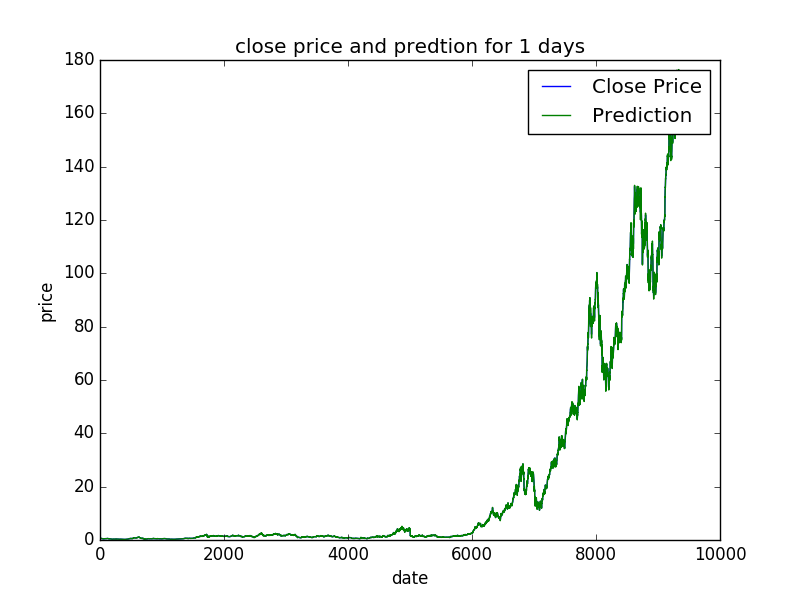

In [19]:
plot_prediction(get_mean_lag(smape_argmin[0],1),1)

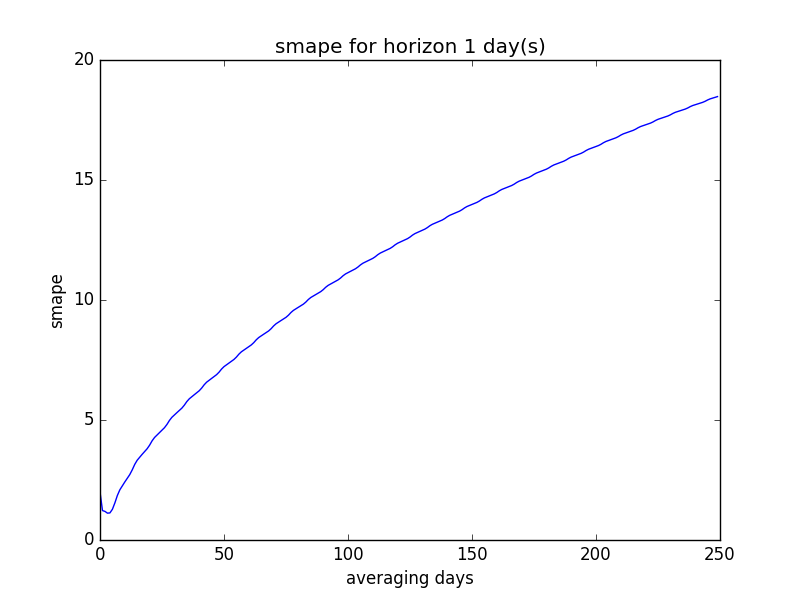

In [20]:
plot_smape(smape_container[0],1)

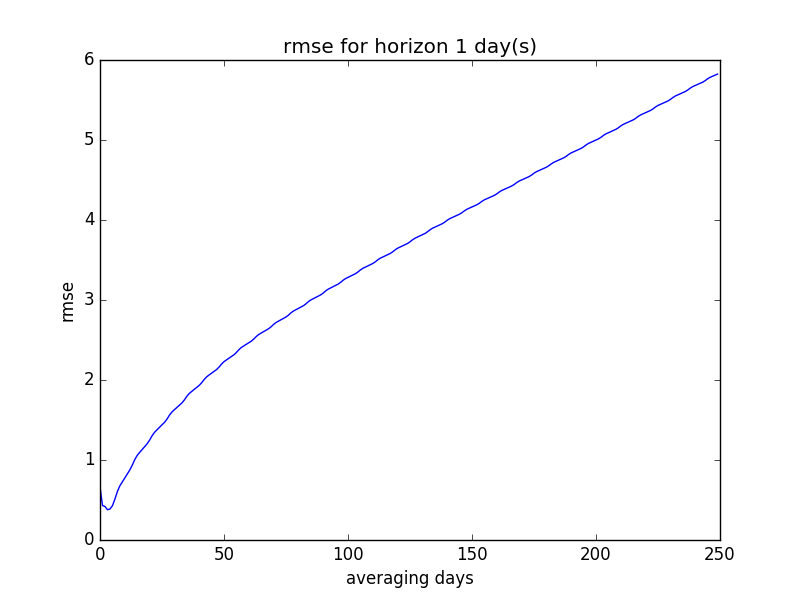

In [21]:
plot_rmse(rmse_container[0],1)

## weekly (5days)

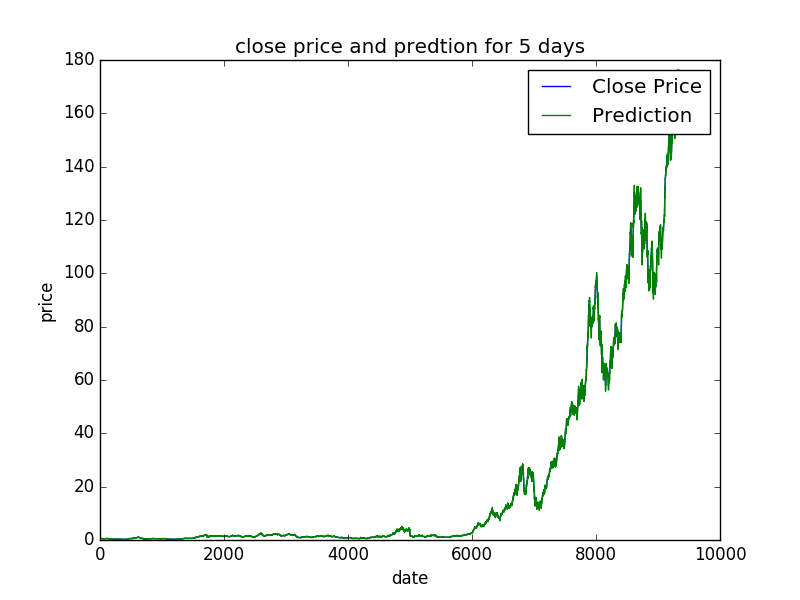

In [23]:
plot_prediction(get_mean_lag(smape_argmin[1],5),5)

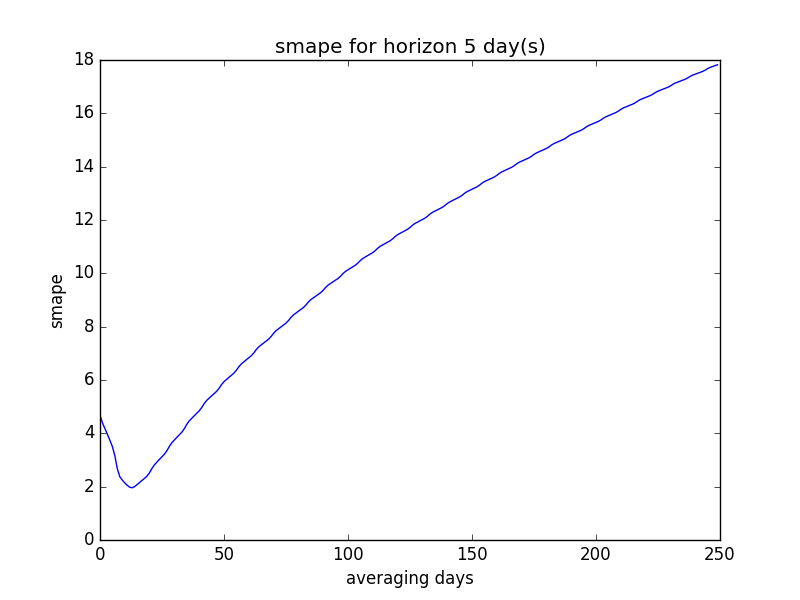

In [24]:
plot_smape(smape_container[1],5)

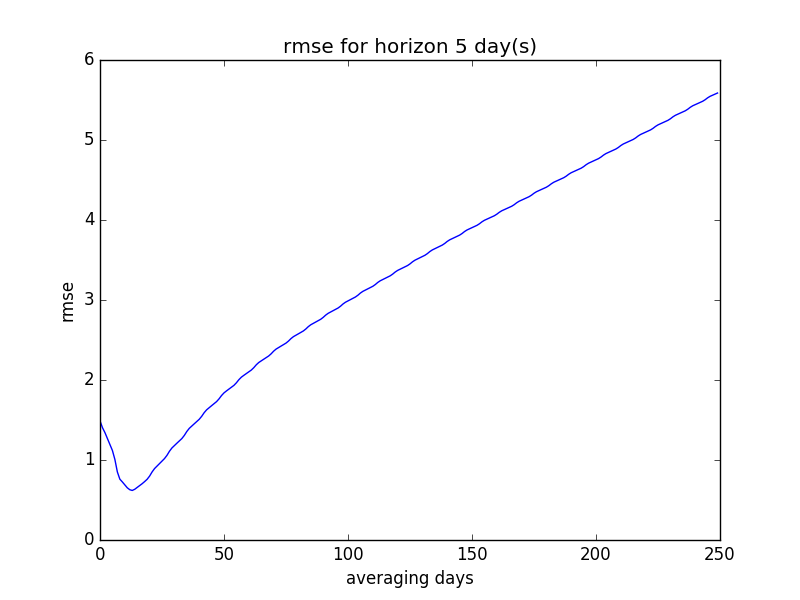

In [25]:
plot_rmse(rmse_container[1],5)

## biweekly (10 days)

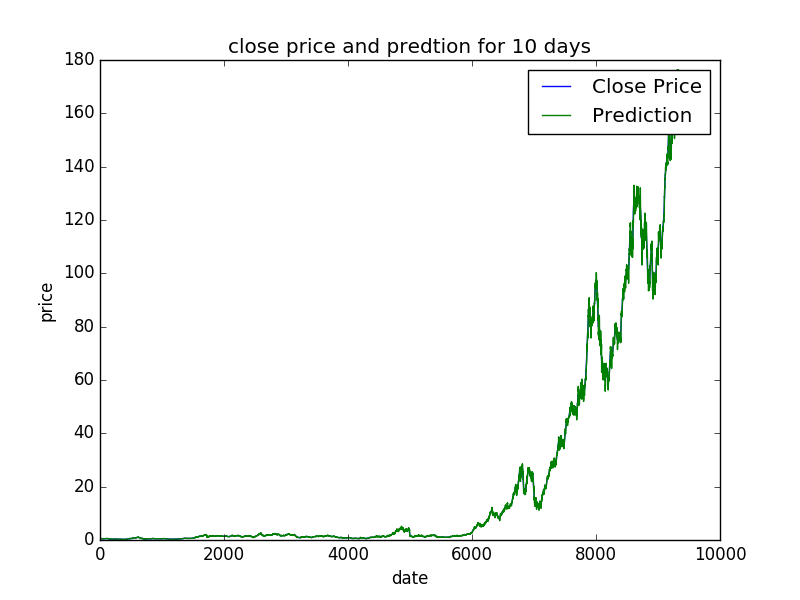

In [27]:
plot_prediction(get_mean_lag(smape_argmin[2],10),10)
#plot_prediction(get_mean_lag(20,10),10)

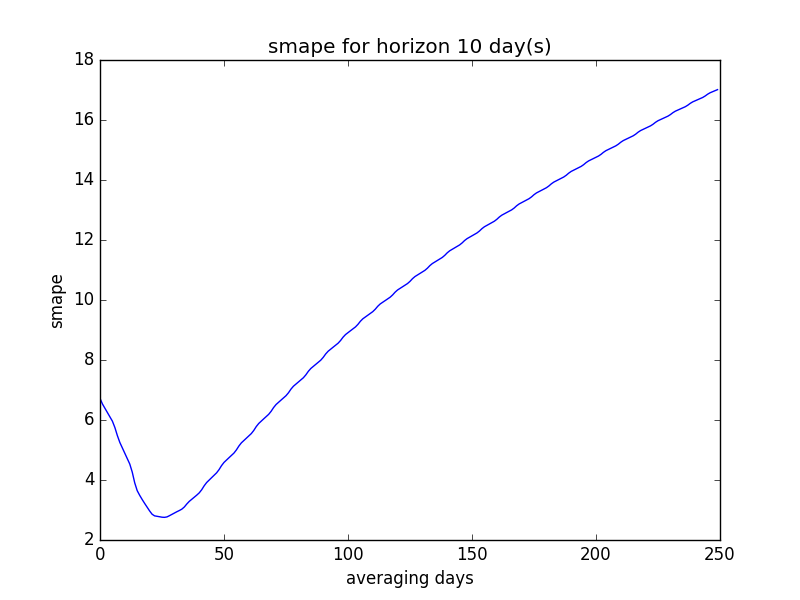

In [28]:
plot_smape(smape_container[2],10)

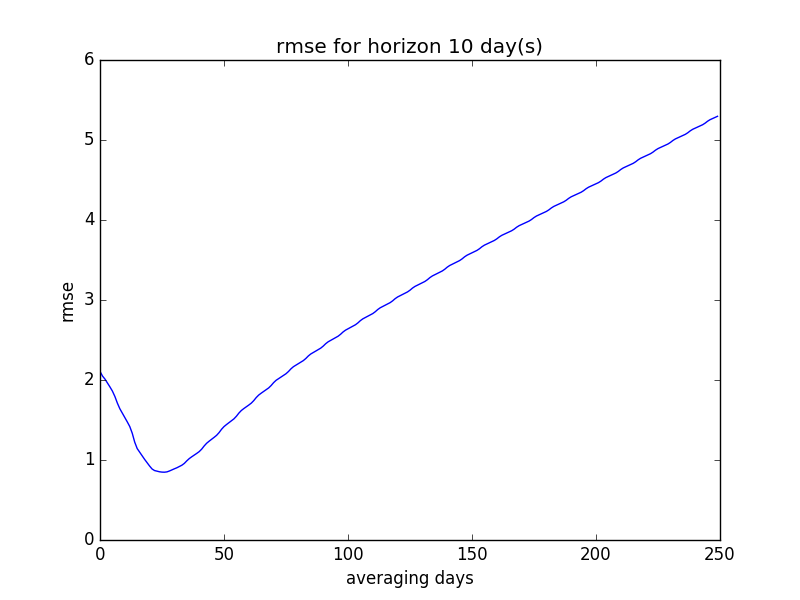

In [29]:
plot_rmse(rmse_container[2],10)

## monthly (21 days)

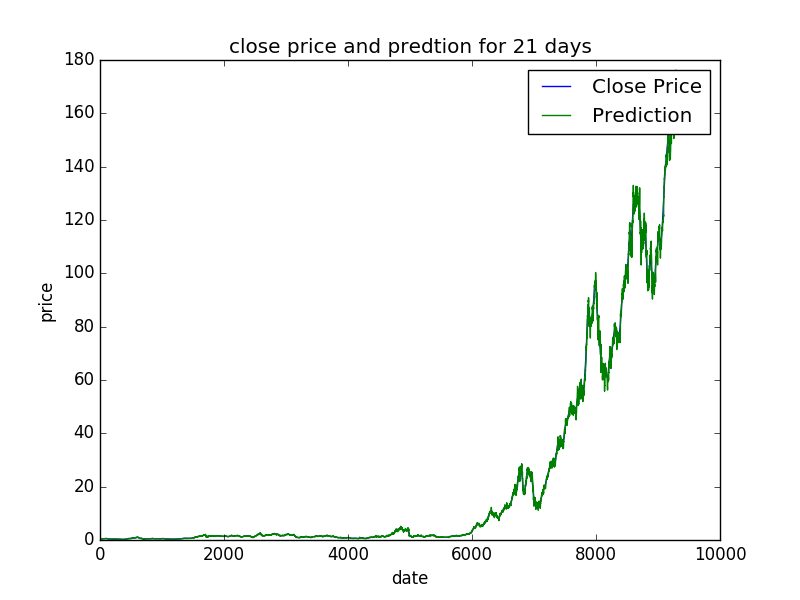

In [31]:
plot_prediction(get_mean_lag(smape_argmin[3],21),21)

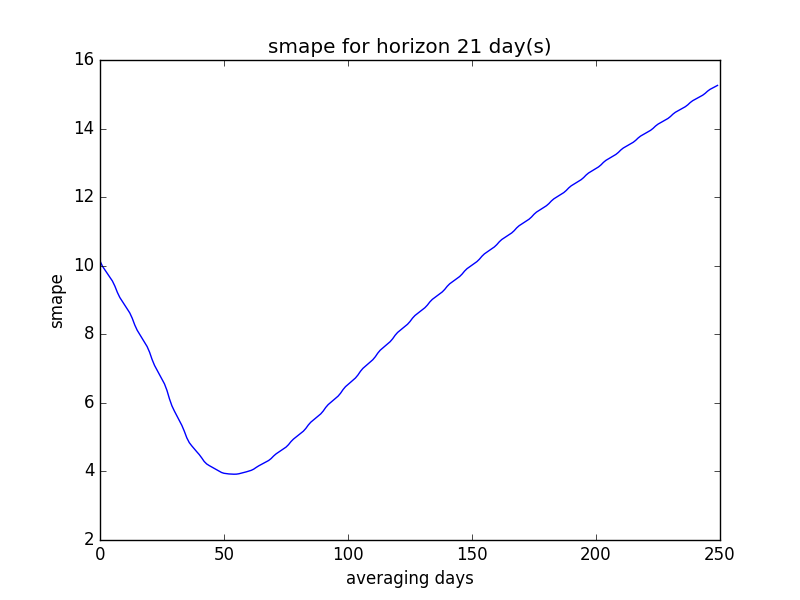

In [32]:
plot_smape(smape_container[3],21)

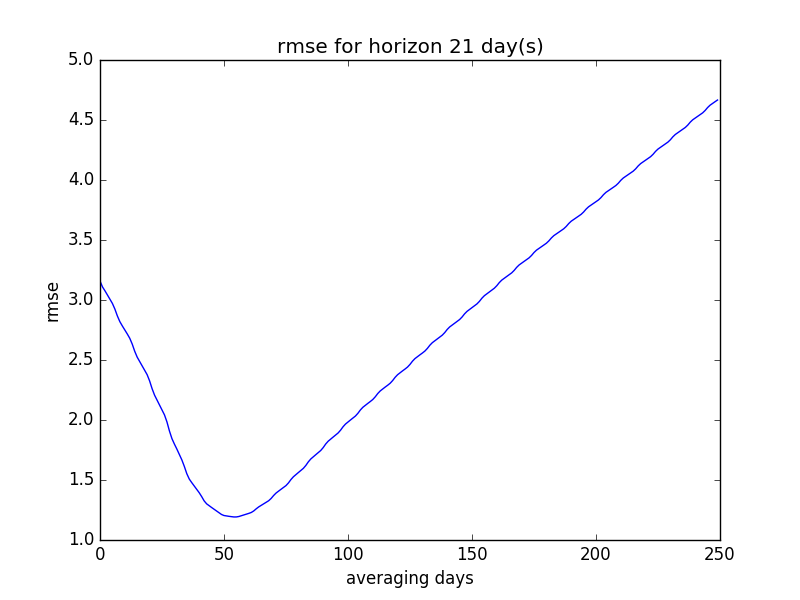

In [33]:
plot_rmse(rmse_container[3],21)

## three months(84 days)

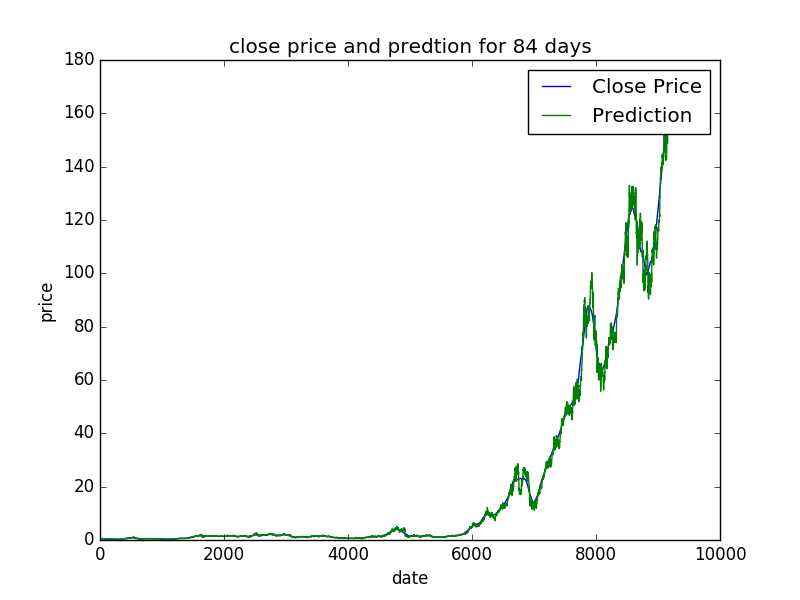

In [35]:
plot_prediction(get_mean_lag(smape_argmin[4],84),84)

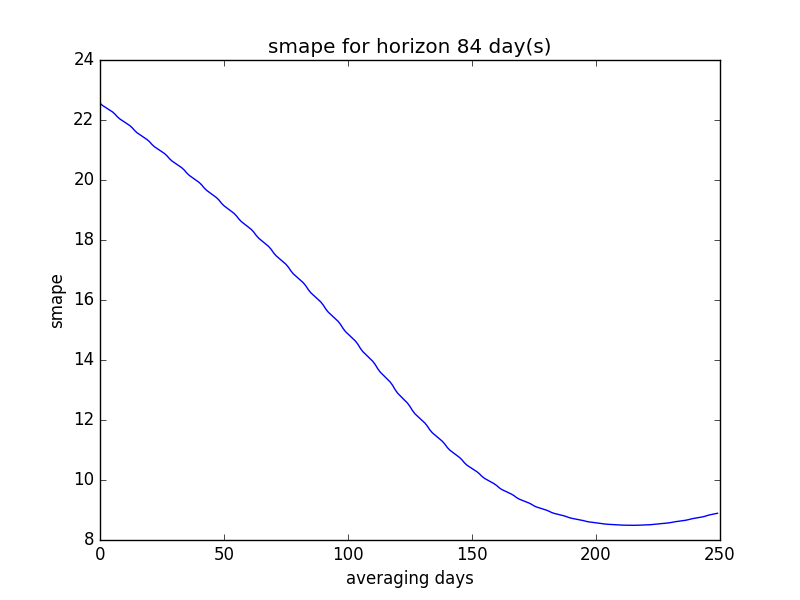

In [36]:
plot_smape(smape_container[4],84)

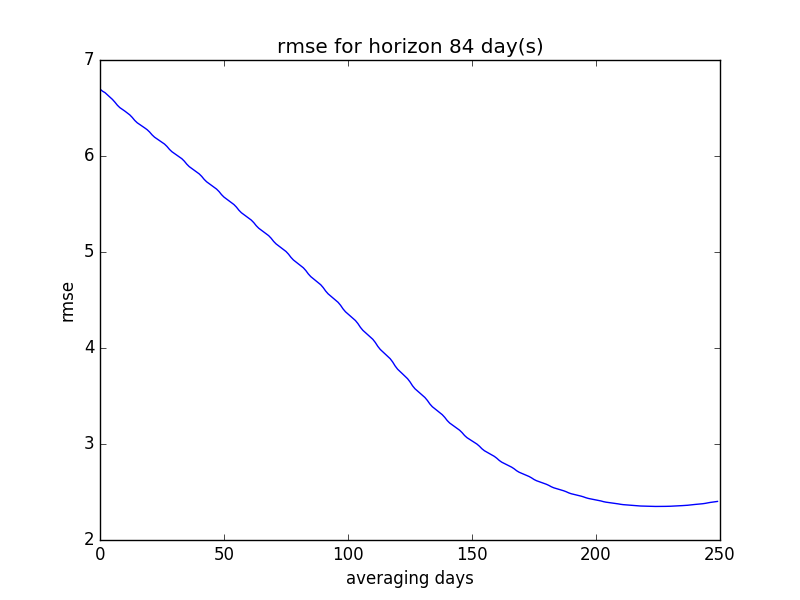

In [37]:
plot_rmse(rmse_container[4],84)